In [1]:
import os
import pandas as pd
from scipy.io import loadmat
from glob import glob

In [2]:
def imlist_to_df(imlist):
    imlist_2d = [s.strip('.tif').split('-') for s in imlist]
    df = pd.DataFrame(imlist_2d, columns=['Cycle','Tile','Channel','Z'])
    df = df.loc[:,['Cycle','Tile','Z']]
    for column in ['Cycle','Tile','Z']:
        df[column] = df[column].apply(lambda x: int(x[1:]))
    return df

even_less = True
cyc_zero = True

channels = ['cy3','cy5','FAM','DAPI']
raw_directory = '/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4'
tile_info = loadmat(os.path.join(raw_directory,'TileInfo.mat'))
tile_num = int(tile_info['TileX'] * tile_info['TileY'])
tiles = [i+1 for i in range(tile_num)]
cycles = glob(os.path.join(raw_directory,'cyc_*')) if not even_less else glob(os.path.join(raw_directory,'cyc_*[13579]'))
cycles += glob(os.path.join(raw_directory,'cyc_0')) if cyc_zero else []

for cycle in cycles:
    channel_info = {}
    for channel in channels:
        print(cycle,channel)
        if glob(os.path.join(cycle,f'*-{channel}-*')):
            channel_info[channel] = imlist_to_df([f for f in os.listdir(cycle) if channel in f])
            z_num = len(channel_info[channel].groupby('Z'))
            print(set(tiles) - set(channel_info[channel]['Tile'].unique()))


/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_1 cy3
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_1 cy5
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_1 FAM
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_1 DAPI
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_3 cy3
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_3 cy5
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_3 FAM
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_3 DAPI
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_5 cy3
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_5 cy5
{1}
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_5 FAM
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_5 DAPI
/Volumes/Users/Dell/Documents/FISH_images/20210707_mouse_brain_4/cyc_7 cy

(2048, 2048, 5)


<ipython-input-4-8f971c16aed1>:59: RuntimeWarning: overflow encountered in exp
  A = np.exp(a+u**2/(2*s**2))
<ipython-input-4-8f971c16aed1>:63: RuntimeWarning: invalid value encountered in multiply
  err = np.sum(np.abs(f_measure - A[:,:,np.newaxis] * np.exp(-(np.arange(len(imlist))-u[:,:,np.newaxis]+1)**2/(2*s[:,:,np.newaxis]**2))),axis=2)


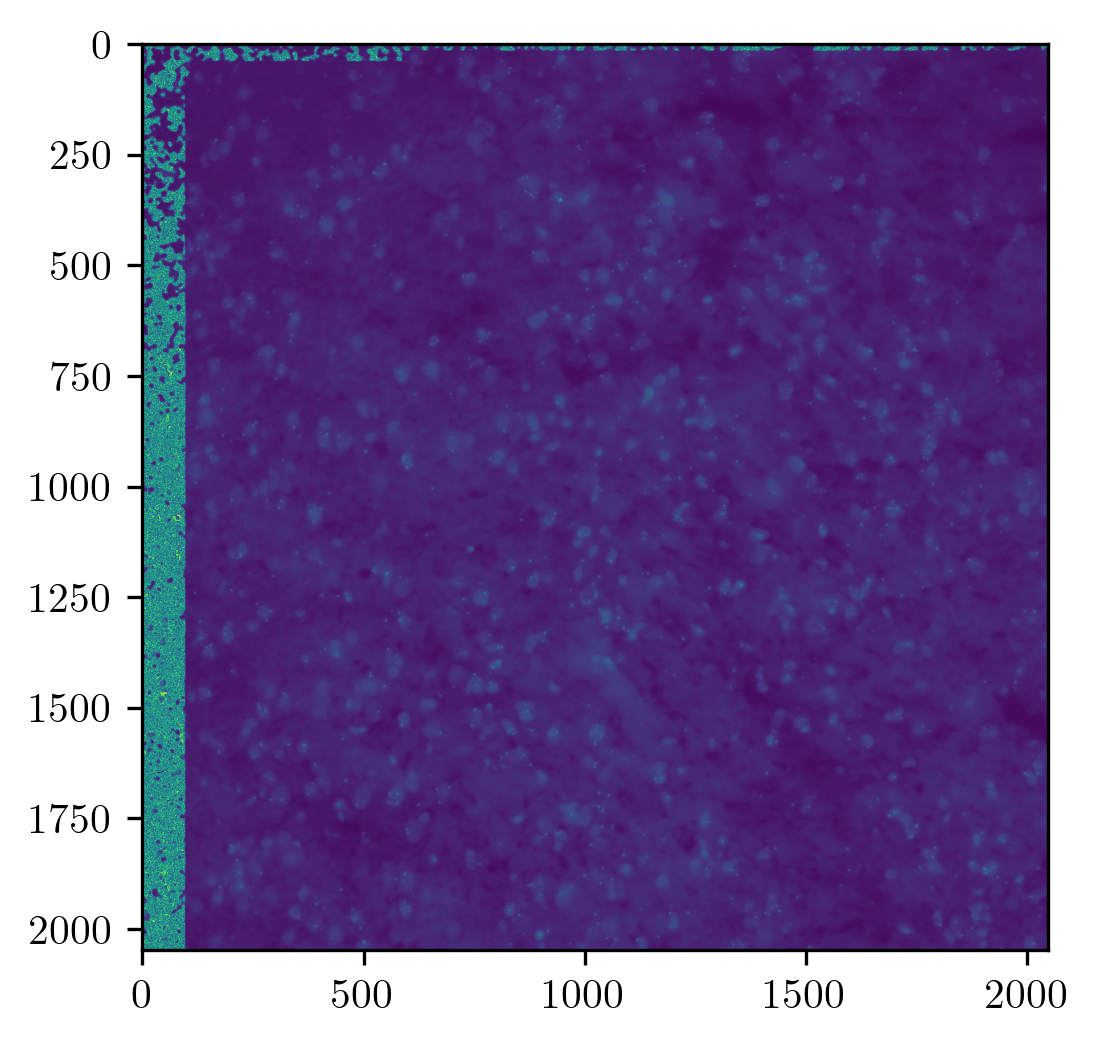

3.297044038772583


In [4]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})
import numpy as np
from skimage import img_as_float
import time
imlist = ['C001-T0026-cy3-Z000.tif','C001-T0026-cy3-Z001.tif','C001-T0026-cy3-Z002.tif','C001-T0026-cy3-Z003.tif','C001-T0026-cy3-Z004.tif']
#im = cv2.imread('C001-T0026-cy3-Z000.tif', -cv2.IMREAD_ANYDEPTH)
#plt.imshow(im)
nhsize=9
focus=1
alpha=0.2
sth=13

def get_focus(im, ksize):
    im_blur = cv2.blur(im,(ksize,ksize))
    im_subtract = (im-im_blur)**2
    return cv2.blur(im_subtract,(ksize,ksize))

tic = time.time()
x,y = 2048,2048
im_seq = np.zeros((x,y,len(imlist)))
x,y,p = im_seq.shape
print(im_seq.shape)
f_measure = np.zeros((x,y,len(imlist)))
for i,im_name in enumerate(imlist):
    im = cv2.imread(im_name, -cv2.IMREAD_ANYDEPTH)
    im_seq[:,:,i] = im
    f_measure[:,:,i] = get_focus(img_as_float(im),9)

def gauss_interpolation(im_seq):
    step = 2
    x,y,p = im_seq.shape
    x_ind,y_ind = np.indices((x,y))
    im_max = np.max(im_seq, axis=2)
    max_ind = np.argmax(im_seq,axis=2)
    ind_mid = max_ind.copy()
    ind_mid[max_ind<=step] = step
    ind_mid[max_ind>=step] = p-step-1
    ind_upper = ind_mid + step
    ind_lower = ind_mid - step
    f_lower = np.log(im_seq[x_ind,y_ind,ind_lower])
    f_mid = np.log(im_seq[x_ind,y_ind,ind_mid])
    f_upper = np.log(im_seq[x_ind,y_ind,ind_upper])
    c = ((f_lower-f_mid)*(ind_mid-ind_upper)-(f_mid-f_upper)*(ind_lower-ind_mid))/((ind_lower**2-ind_mid**2)*(ind_mid-ind_upper)-(ind_mid**2-ind_upper**2)*(ind_lower-ind_mid))
    b = ((f_mid-f_upper)-c*(ind_mid-ind_upper)*(ind_mid+ind_upper))/(ind_mid-ind_upper)
    s_squared = -1/(2*c)
    s_squared[s_squared<0]=1e-9
    s = np.sqrt(s_squared)
    u = b*s**2
    a = f_lower - b * ind_lower - c * ind_lower**2
    A = np.exp(a+u**2/(2*s**2))
    return u,s,A,im_max

u,s,A,im_max = gauss_interpolation(f_measure)
err = np.sum(np.abs(f_measure - A[:,:,np.newaxis] * np.exp(-(np.arange(len(imlist))-u[:,:,np.newaxis]+1)**2/(2*s[:,:,np.newaxis]**2))),axis=2)
inv_psnr = cv2.blur(err/(im_max * p),(nhsize,nhsize))
S = 20 * np.log10(1/inv_psnr)
S[np.isnan(S)] = np.nanmin(S)
phi = 0.5*(1+np.tanh(alpha*(S-sth)))/alpha
phi = cv2.blur(phi,(3,3))
phi = phi[:,:,np.newaxis] * np.ones(p)

f_measure = 0.5 + 0.5 * np.tanh(phi*(f_measure-1))
nm_fac = np.sum(f_measure, axis=2)
im_out = np.uint16(np.sum(im_seq,axis=2)/nm_fac)
plt.imshow(im_out)
plt.show()

print(time.time()-tic)
def fstack(imlist, nhsize=9, focus=1, alpha=0.2, sth=13):
    pass

In [156]:
cv2.imwrite('im_out.tif',im_out)

True

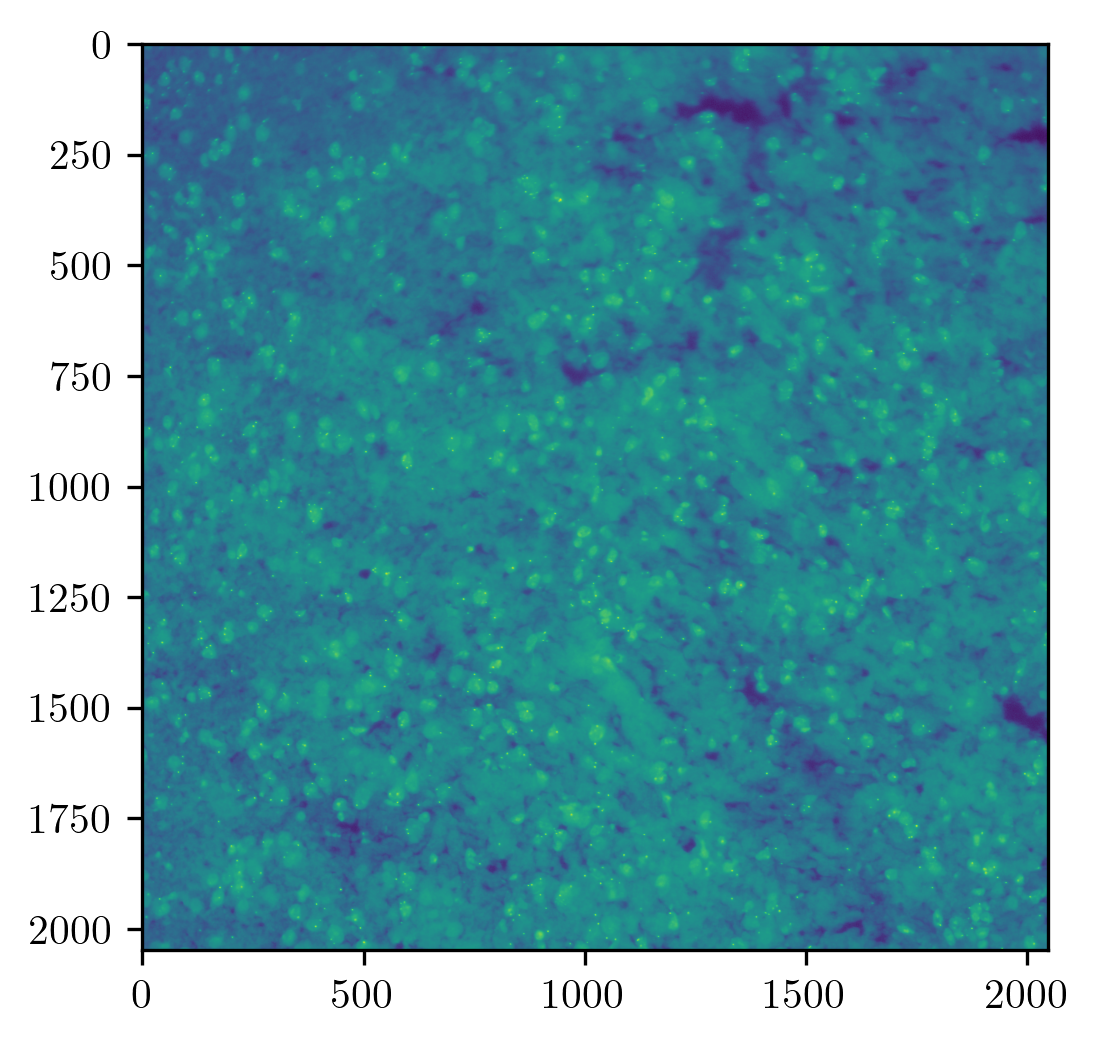

In [78]:
plt.imshow(f_mid)
plt.show()